https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier

# TRAINING A CLASSIFIER

## Training An Image Classifier

### 1. Loading and normalizing CIFAR10

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


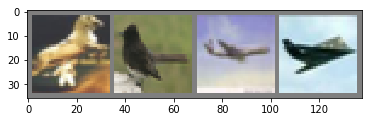

horse  bird plane plane


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some train images randamly
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3. Define a Loss function and optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [6]:
epochs = 2

for epoch in range(epochs): # loop over the dataset 'epochs' times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        
        # Zero the gradient of the parameters
        optimizer.zero_grad()
        
        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2,000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished training!')

[1,  2000] loss: 2.199
[1,  4000] loss: 1.871
[1,  6000] loss: 1.690
[1,  8000] loss: 1.567
[1, 10000] loss: 1.528
[1, 12000] loss: 1.456
[2,  2000] loss: 1.392
[2,  4000] loss: 1.371
[2,  6000] loss: 1.372
[2,  8000] loss: 1.333
[2, 10000] loss: 1.295
[2, 12000] loss: 1.297
Finished training!


### 5. Test the network on the test data

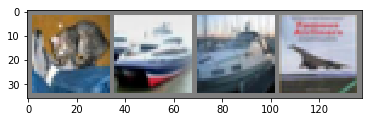

Ground truth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
inputs, labels = dataiter.next()

# Print images
imshow(torchvision.utils.make_grid(inputs))
print('Ground truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
outputs = net(inputs)

In [9]:
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship plane


In [10]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (labels == predicted).sum().item()
        total += images.size(0)

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53.61 %


In [11]:
class_correct_list = list(0 for i in range(10))
class_total_list = list(0 for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(4):
            label = labels[i]
            class_correct_list[label] += c[i].item()
            class_total_list[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct_list[i] / class_total_list[i]))

Accuracy of plane : 61 %
Accuracy of   car : 75 %
Accuracy of  bird : 23 %
Accuracy of   cat : 29 %
Accuracy of  deer : 46 %
Accuracy of   dog : 27 %
Accuracy of  frog : 77 %
Accuracy of horse : 71 %
Accuracy of  ship : 56 %
Accuracy of truck : 67 %


## Training On GPU

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [13]:
net.to(device) # <----- Important!
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # <----- Important!

epochs = 2
for epoch in range(epochs): # loop over the dataset 'epochs' times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # <----- Important!
        
        # Zero the gradient of the parameters
        optimizer.zero_grad()
        
        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2,000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished training!')

[1,  2000] loss: 1.222
[1,  4000] loss: 1.213
[1,  6000] loss: 1.213
[1,  8000] loss: 1.218
[1, 10000] loss: 1.197
[1, 12000] loss: 1.199
[2,  2000] loss: 1.121
[2,  4000] loss: 1.135
[2,  6000] loss: 1.120
[2,  8000] loss: 1.139
[2, 10000] loss: 1.113
[2, 12000] loss: 1.121
Finished training!
